### packages

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import xarray
import funcs as f

%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

In [2]:
fs=14
plt.rc("font",size=fs)

### parameters

In [3]:
outpath       = "/Volumes/Baby-Orange/XPIA-NCAR/processed/"
datapath      = "/Volumes/Baby-Orange/XPIA-NCAR/rawest/"
z_zi_target   = 0.5

In [4]:
keys_in_order = ['LES_raw', 'LES', 'vles', 'mynn', 'ysu', 'sh']

### io

In [5]:
convective      = pd.read_csv(os.path.join(outpath,"datetimes_ziL_gt_25.csv"),header=None,index_col=[0])
convective_list = np.array([ pd.Timestamp(l[0]) for l in convective.values.tolist() ])
nt              = len(convective_list)
print(nt)

269


In [6]:
days=[20,21,28,29,30]

for iday,day in enumerate(days):
    path = "/Volumes/Baby-Orange/XPIA-NCAR/processed/PBLH_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
    tmp = pd.read_csv(path, index_col=[0], parse_dates=True)
    tmp = tmp['median'].copy()
    if iday==0:
        df_zi = tmp.copy()
    else:
        df_zi = pd.concat([df_zi,tmp],axis=0)

### a little cleaner when choosing just one variable without wspd, wdir

In [164]:
varname = "w"

nt = 1

datetimes = []

data      = {}
for key in ['sh','vles','mynn','ysu']:
    data[key] = np.zeros((nt,90,90))
for key in ['LES','LES_raw',]:
    data[key] = np.zeros((nt,1200,1200))   


year    = 2015
month   = 3
days    = [28] #20
hours   = [20] #np.arange(14,24,1)
minutes = [10]  #np.arange(0,60,10)

ks = []

it = 0
for day in days:
    for hour in hours:
        for minute in minutes:
            sys.stdout.write('\r'+str(it))
            datetime = pd.Timestamp(year=year,month=month,day=day,hour=hour,minute=minute)
            datetimes.append(datetime)
            zi       = df_zi.loc[datetime]
           
            xy_primes, xy_means, k = f.get_prime_and_means(datapath, datetime, zi, varname=varname, z_zi_target=z_zi_target)            
            
            ks.append(k)
            for key in xy_primes.keys():
                data[key][it,...] = xy_primes[key].copy()   
            it+=1

0

### do it manually for wind speed and direction

In [165]:
nt = 1

datetimes = []

u   = {}
v   = {}
for key in ['sh','vles','mynn','ysu']:
    u[key] = np.zeros((nt,90,90))
    v[key] = np.zeros((nt,90,90))    
for key in ['LES','LES_raw',]:
    u[key] = np.zeros((nt,1200,1200))   
    v[key] = np.zeros((nt,1200,1200))       

sims=["LES","vles","mynn","ysu","sh"]

# year    = 2015
# month   = 3
# days    = [30] #20
# hours   = np.arange(14,24,1)
# minutes = np.arange(0,60,10)

it = 0
for day in days:
    for hour in hours:
        for minute in minutes:
            sys.stdout.write('\r'+str(it))
            
            datetime     = pd.Timestamp(year=year,month=month,day=day,hour=hour,minute=minute)
            datetime_str = "{0:%Y-%m-%d_%H:%M}".format(datetime)            
            datetimes.append(datetime)
            
            zi = df_zi.loc[datetime]
            
            for sim in sims:        

                sim_prefix      = sim+"_25m" if sim=="LES" else sim
                fpath           = os.path.join(datapath,"WRF_{0}_3D_{1}_plus_filtered.nc".format(sim_prefix,datetime_str))    
                datatmp         = xarray.open_dataset(fpath)
                #datatmp["ws_filt"] = np.sqrt(data["u_filt"]**2+data["v_filt"]**2)
                #datatmp["wd_filt"] = 180.0 + np.degrees(np.arctan2(data["v_filt"],data["u_filt"]))            

                z         = datatmp['z'].copy()
                zmean     = np.median(z.values,axis=(1,2))
                z_zi      = zmean/zi    
                k         = np.argmin(np.abs(z_zi-z_zi_target))    

                u[sim][it,...] = datatmp['u_filt'].squeeze().values[k,...].copy()
                v[sim][it,...] = datatmp['v_filt'].squeeze().values[k,...].copy()

                if sim=="LES":                
                
                    u[sim+"_raw"][it,...]      = datatmp["u"].squeeze().values[k,...].copy()
                    v[sim+"_raw"][it,...]      = datatmp["v"].squeeze().values[k,...].copy()
                
            it+=1

0

### first figure

In [166]:
# coords = {}
# for key in data.keys():
#     npts,npts = data[key][0,...].shape
#     delta = 333.0 if npts<500 else 25.0
#     coords[key] = np.arange(delta/2.,30000,delta)

In [167]:
coords = {}
for key in u.keys():
    npts,npts = u[key][0,...].shape
    delta = 333.0 if npts<500 else 25.0
    coords[key] = np.arange(delta/2.,30000,delta)

# w

In [168]:
fs=16
plt.rc("font",size=fs)

In [169]:
np.max(data["mynn"][i,...])

4.641481470508662

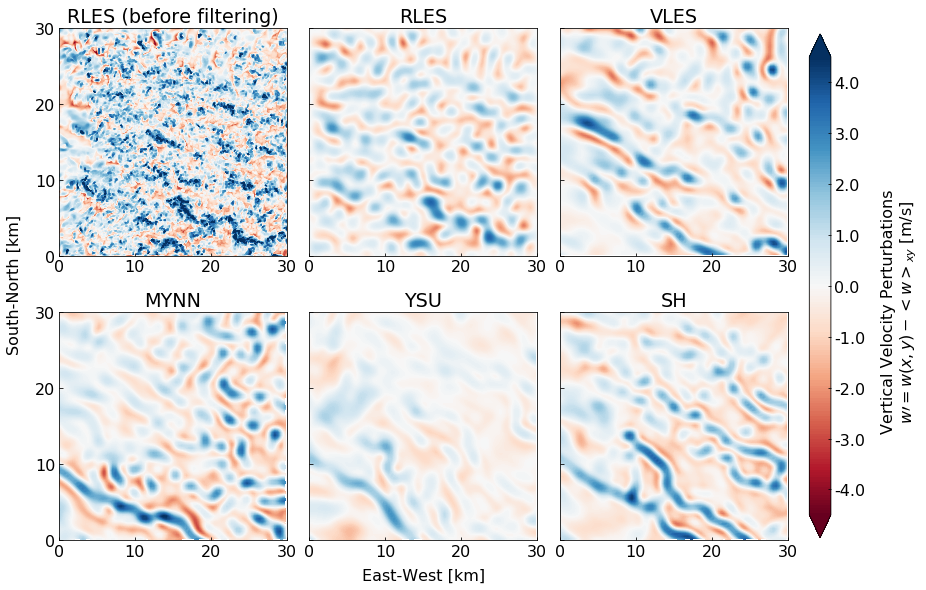

In [170]:
vlim = 4.5

i = 0

fig = plt.figure(figsize=(3*5,2*5))

axbig = fig.add_subplot(111)
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)#     axbig.set_xlabel("$y_{rotor} - \Delta y_{wake}$",labelpad=-5)
axbig.set_ylabel("South-North [km]")
axbig.set_xlabel("East-West [km]", labelpad=-10)
# axbig.set_title(datetimes[i])

axs = {}
p   = {}
uv  = {}

for iax,sim in enumerate(keys_in_order):
    
    axs[iax] = fig.add_subplot(2,3,iax+1,aspect="equal")
    
    x = (coords[sim]/1000)
    #p[sim] = axs[iax].contourf(np.zeros((10,10))+100)
    p[sim] = axs[iax].contourf(x, x, data[sim][i,...], levels=np.arange(-vlim,vlim+0.01,0.05), cmap='RdBu', extend='both')
    
    if sim.lower()=="les":
        simlab = "RLES"
    elif sim.lower()=="les_raw":
        simlab = "RLES (before filtering)"
    else:
        simlab = sim.upper()
        
    axs[iax].set_title(simlab)
    #plt.colorbar(p)
    
    axs[iax].set_xticks([0,10,20,30])
    axs[iax].set_yticks([0,10,20,30])       
    
    if iax in [1,2,4,5]:
        plt.setp(axs[iax].get_yticklabels(), visible=False)
        
    axs[iax].xaxis.set_tick_params(direction='in')
    axs[iax].yaxis.set_tick_params(direction='in')               

fig.subplots_adjust(right=0.8, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
clb = fig.colorbar(p[sim], cax=cbar_ax, format=FormatStrFormatter('%3.1f'), ticks=np.arange(-5,5+0.01,1))
clb.set_label('Vertical Velocity Perturbations\n$w\prime=w(x,y) - <w>_{{xy}}$ [m/s]', labelpad=15, y=0.45)
clb.ax.tick_params(direction='in')     

fig.savefig("../figs/{0}_{1:%Y-%m-%d_%H-%M}_all_sims.png".format("w",datetimes[i]), dpi=350, bbox_inches="tight")

### wdir/wspd

In [140]:
nskip_les = 90
nskip_gz  = 7

In [176]:
np.max(np.sqrt(u["LES_raw"][i,...]**2 + v["LES_raw"][i,...]**2))

17.833246400634618

In [177]:
umin = 4#0
umax = 18#6.5

In [178]:
# convective_list

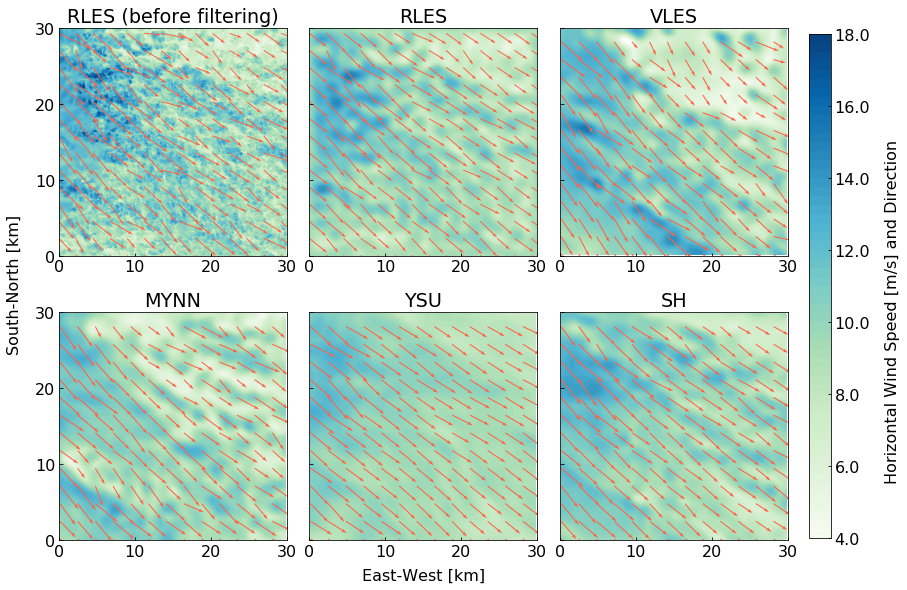

In [179]:
i = 0 

fig = plt.figure(figsize=(3*5,2*5))

axbig = fig.add_subplot(111)
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)#     axbig.set_xlabel("$y_{rotor} - \Delta y_{wake}$",labelpad=-5)
axbig.set_ylabel("South-North [km]")
axbig.set_xlabel("East-West [km]", labelpad=-10)
# axbig.set_title(datetimes[i])

axs = {}
p   = {}
uv  = {}

for iax,sim in enumerate(keys_in_order):
    
    nskip = nskip_les if ((sim=="LES") or (sim=="LES_raw")) else nskip_gz
    
    axs[iax] = fig.add_subplot(2,3,iax+1,aspect="equal")
    
    ws = np.sqrt(u[sim][i,...]**2 + v[sim][i,...]**2)
    
    x = (coords[sim]/1000)
    p[sim]  = axs[iax].contourf(x, x, ws, levels=np.arange(umin,umax+0.1,0.25), cmap='GnBu')
    uv[sim] = axs[iax].quiver(  x[::nskip], x[::nskip], u[sim][i,...][::nskip,::nskip], v[sim][i,...][::nskip,::nskip], color='tomato',units='xy', lw=3, scale_units='inches',scale=30)      

    if sim.lower()=="les":
        simlab = "RLES"
    elif sim.lower()=="les_raw":
        simlab = "RLES (before filtering)"
    else:
        simlab = sim.upper()
        
    axs[iax].set_title(simlab)
    #plt.colorbar(p)
    
    axs[iax].set_xticks([0,10,20,30])
    axs[iax].set_yticks([0,10,20,30])       
    
    if iax in [1,2,4,5]:
        plt.setp(axs[iax].get_yticklabels(), visible=False)      
        
    axs[iax].xaxis.set_tick_params(direction='in')
    axs[iax].yaxis.set_tick_params(direction='in')   
    
    #qk = axs[iax].quiverkey(uv[sim], 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E', coordinates='figure')    
        
fig.subplots_adjust(right=0.8, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
clb = fig.colorbar(p[sim], cax=cbar_ax, format=FormatStrFormatter('%3.1f'), ticks=np.arange(umin,umax+0.01,2))
clb.set_label('Horizontal Wind Speed [m/s] and Direction', labelpad=15, y=0.45)
clb.ax.tick_params(direction='in')     
fig.savefig("../figs/{0}_{1:%Y-%m-%d_%H-%M}_all_sims.png".format("quiver",datetimes[i]), dpi=350, bbox_inches="tight")

### next figs

# ws

In [115]:
def animate(i):
    
    datetime = datetimes[i]
    
    for iax,sim in enumerate(keys_in_order): 
        
        nskip = nskip_les if ((sim=="LES") or (sim=="LES_raw")) else nskip_gz
        ws    = np.sqrt(u[sim][i,...]**2 + v[sim][i,...]**2)        
        x     = (coords[sim]/1000)-np.mean(coords[sim]/1000)        
        
        
        axs[iax].collections = []        
        p[sim]  = axs[iax].contourf(x, x, ws, levels=np.arange(0.0,umax+0.1,0.5), cmap='GnBu')
        uv[sim] = axs[iax].quiver(  x[::nskip], x[::nskip], u[sim][i,...][::nskip,::nskip], v[sim][i,...][::nskip,::nskip], color='k',units='xy', lw=2, scale_units='inches',scale=30)      

    axbig.set_title(datetime)        

In [116]:
anim = FuncAnimation(fig, animate, interval=400, frames=range(nt))

In [117]:
anim.save("../figs/ws_quiver_March{0}_good.mp4".format(day))

# w

In [14]:
def animate(i):
    
    datetime = datetimes[i]
    
    for iax,sim in enumerate(keys_in_order):    
        axs[iax].collections = []
        x = (coords[sim]/1000)-np.mean(coords[sim]/1000)        
        p[sim] = axs[iax].contourf(x, x, data[sim][i,...], levels=np.arange(-vlim,vlim+0.01,0.05), cmap='RdBu')

    axbig.set_title(datetime)        

In [15]:
anim = FuncAnimation(fig, animate, interval=400, frames=range(nt))

In [16]:
day

20

In [17]:
anim.save("../figs/w_March{0}_good.mp4".format(day))